**Importing Libraries**

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

**Creating Spark Session**

In [2]:
spark = SparkSession.builder.appName("DataBricks").getOrCreate()
spark

**Uploading required files**

In [3]:
from google.colab import files
uploaded = files.upload()

Saving attendance.csv to attendance.csv
Saving employees.csv to employees.csv
Saving tasks.csv to tasks.csv


**Loading Files**

In [4]:
dfAtt = spark.read.csv(r"/content/attendance.csv", header=True, inferSchema=True)
dfEmp = spark.read.csv(r"/content/employees.csv", header=True, inferSchema=True)
dfTas = spark.read.csv(r"/content/tasks.csv", header=True, inferSchema=True)

**Printing Files**

In [5]:
dfAtt.show()

+------------+----------+----------+----------------+----------------+------+---------+
|attendanceID|employeeID|      date|         clockIN|        clockOUT|isLate|isAbscent|
+------------+----------+----------+----------------+----------------+------+---------+
|           1|         1|01-06-2024|01-06-2024 09:02|01-06-2024 17:00|     1|        0|
|           2|         2|01-06-2024|01-06-2024 08:55|01-06-2024 17:10|     0|        0|
|           3|         3|01-06-2024|01-06-2024 09:10|01-06-2024 17:05|     1|        0|
|           4|         4|01-06-2024|01-06-2024 08:48|01-06-2024 17:15|     0|        0|
|           5|         5|01-06-2024|            NULL|            NULL|     0|        1|
|           6|         1|02-06-2024|02-06-2024 08:50|02-06-2024 17:00|     0|        0|
|           7|         2|02-06-2024|02-06-2024 09:20|02-06-2024 17:10|     1|        0|
|           8|         3|02-06-2024|            NULL|            NULL|     0|        1|
|           9|         4|02-06-2

In [6]:
dfEmp.show()

+----------+-------------+-----------+------------------+--------------------+----------+--------+
|employeeID|         name| department|              role|               email|  hireDate|  status|
+----------+-------------+-----------+------------------+--------------------+----------+--------+
|         1|     John Doe|Engineering|Software Developer|john.doe@example.com|2023-01-15|  Active|
|         2|   Jane Smith|  Marketing|Content Strategist|jane.smith@exampl...|2022-11-20|  Active|
|         3|Alice Johnson|         HR|        HR Manager|alice.johnson@exa...|2021-09-10|  Active|
|         4|    Bob Brown|Engineering|   DevOps Engineer|bob.brown@example...|2023-05-01|  Active|
|         5|    Eva Green|    Finance|        Accountant|eva.green@example...|2022-06-30|Resigned|
+----------+-------------+-----------+------------------+--------------------+----------+--------+



In [7]:
dfTas.show()

+------+----------+--------------------+----------+---------------+
|taskID|employeeID|            taskName|  taskDate|tasksCompeleted|
+------+----------+--------------------+----------+---------------+
|     1|         1|     API Integration|2024-06-01|              5|
|     2|         2|Content Calendar ...|2024-06-01|              3|
|     3|         3|       Policy Review|2024-06-01|              0|
|     4|         4|         CI/CD Setup|2024-06-01|              4|
|     5|         5|    Invoice Auditing|2024-06-01|              6|
|     6|         1|    Backend Refactor|2024-06-02|              4|
|     7|         2|Email Campaign De...|2024-06-02|              2|
|     8|         3|Employee Feedback...|2024-06-02|              0|
|     9|         4|        Docker Setup|2024-06-02|              5|
|    10|         5|Expense Sheet Val...|2024-06-02|              3|
|    11|         1|    API Docs Writing|2024-06-03|              5|
|    12|         2|Marketing Funnel ...|2024-06-

**Printing Schemas**

In [8]:
dfAtt.printSchema()

root
 |-- attendanceID: integer (nullable = true)
 |-- employeeID: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- clockIN: string (nullable = true)
 |-- clockOUT: string (nullable = true)
 |-- isLate: integer (nullable = true)
 |-- isAbscent: integer (nullable = true)



In [9]:
dfEmp.printSchema()

root
 |-- employeeID: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- department: string (nullable = true)
 |-- role: string (nullable = true)
 |-- email: string (nullable = true)
 |-- hireDate: date (nullable = true)
 |-- status: string (nullable = true)



In [10]:
dfTas.printSchema()

root
 |-- taskID: integer (nullable = true)
 |-- employeeID: integer (nullable = true)
 |-- taskName: string (nullable = true)
 |-- taskDate: date (nullable = true)
 |-- tasksCompeleted: integer (nullable = true)



**Cleaning Datas**

In [11]:
dfEmp = dfEmp.dropna()
dfTas = dfTas.dropna()

**Joining Data**

In [12]:
dfJoined = dfAtt.join(dfEmp, on="employeeID", how="inner").join(dfTas, on="employeeID", how="inner")

**Department level metrics**

In [13]:
deptAttendance = dfAtt.join(dfEmp, "employeeID", "inner").groupBy("department").agg(
        F.sum("isLate").alias("LateCount"),
        F.sum("isAbscent").alias("AbscentCount")
    )

dfJoined = dfAtt.join(dfEmp, "employeeID", "inner").join(dfTas, "employeeID", "inner")

dfJoined = dfJoined.withColumn(
    "hoursWorked",
    F.round(
        (F.unix_timestamp("clockOUT", "dd-MM-yyyy HH:mm") -
         F.unix_timestamp("clockIN", "dd-MM-yyyy HH:mm")) / 3600, 2
    )
).withColumn(
    "productivityScore",
    F.when(F.col("hoursWorked") > 0, F.round(F.col("tasksCompeleted")/F.col("hoursWorked"), 2)).otherwise(0)
)

deptProductivity = dfJoined.groupBy("department").agg(
        F.round(F.mean("hoursWorked"), 2).alias("AverageWorkHours"),
        F.round(F.mean("productivityScore"), 2).alias("AverageProductivityScore"),
        F.sum("tasksCompeleted").alias("TotalTasksCompleted")
    )

deptMetrics = deptAttendance.join(deptProductivity, "department", "inner")

deptMetrics.show()


+-----------+---------+------------+----------------+------------------------+-------------------+
| department|LateCount|AbscentCount|AverageWorkHours|AverageProductivityScore|TotalTasksCompleted|
+-----------+---------+------------+----------------+------------------------+-------------------+
|Engineering|        4|           1|            8.02|                    0.48|                300|
|         HR|        2|           2|            8.08|                    0.04|                 18|
|    Finance|        2|           2|            7.87|                    0.25|                108|
|  Marketing|        3|           1|            8.07|                    0.26|                 90|
+-----------+---------+------------+----------------+------------------------+-------------------+



**Saving file**

In [18]:
deptMetrics.write.mode("overwrite").csv("/content/deptMetrics.csv")

**Basic visualization**

<Axes: xlabel='department'>

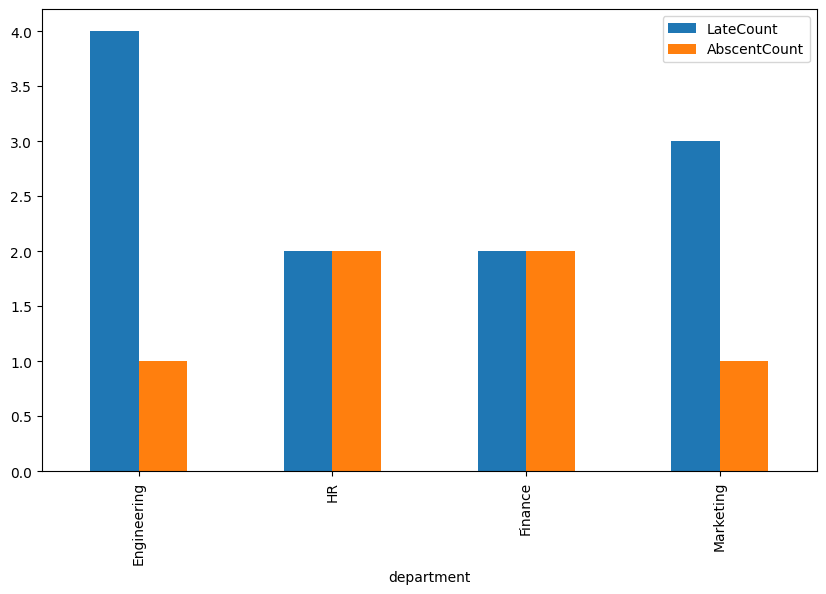

In [15]:
visual = deptMetrics.toPandas()
visual.plot.bar(x="department", y=["LateCount", "AbscentCount"], figsize=(10,6))

<Axes: xlabel='department'>

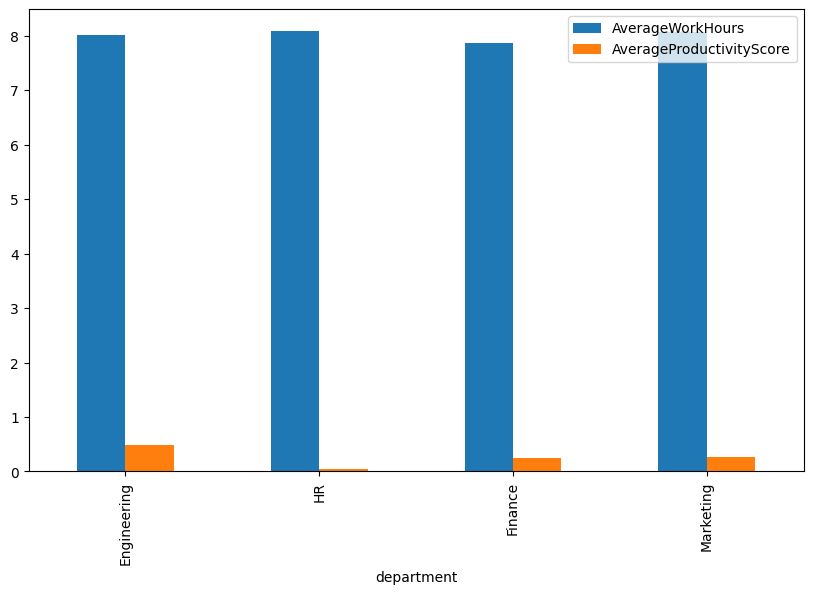

In [16]:
visual.plot.bar(x="department", y=["AverageWorkHours", "AverageProductivityScore"], figsize=(10,6))

<Axes: ylabel='TotalTasksCompleted'>

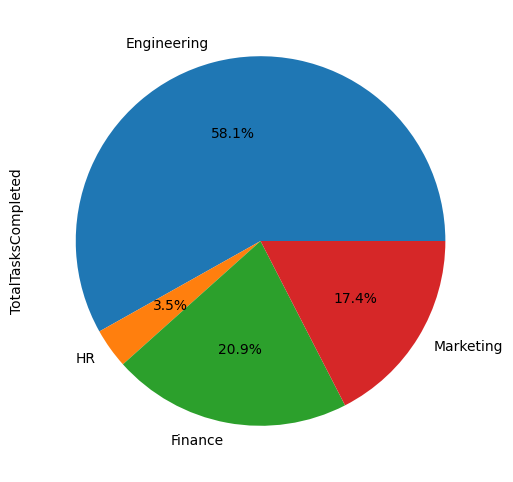

In [17]:
visual.set_index("department")["TotalTasksCompleted"].plot.pie(
    autopct="%1.1f%%", figsize=(10, 6)
)

**Delieverables**

In [19]:
#Databricks notebook with full ETL process

In [23]:
# Exported file showing attendance and task KPIs

# Department metrices
deptMetrics.coalesce(1) \
    .write.mode("overwrite").option("header", True) \
    .csv("/content/deptMetrics")

# Attendance KPI
deptMetrics.select(["department", "LateCount", "AbscentCount", "AverageWorkHours"]) \
    .coalesce(1) \
    .write.mode("overwrite").option("header", True) \
    .csv("/content/attendanceKPI")

# Task KPI
deptMetrics.select(["department", "AverageProductivityScore", "TotalTasksCompleted"]) \
    .coalesce(1) \
    .write.mode("overwrite").option("header", True) \
    .csv("/content/taskKPI")

In [24]:
import shutil, glob

# Department metrices
dept_file = glob.glob("/content/deptMetrics/part-*.csv")[0]
shutil.move(dept_file, "/content/deptMetrics.csv")

# Attendance KPI
attendance_file = glob.glob("/content/attendanceKPI/part-*.csv")[0]
shutil.move(attendance_file, "/content/attendanceKPI.csv")

# Task KPI
task_file = glob.glob("/content/taskKPI/part-*.csv")[0]
shutil.move(task_file, "/content/taskKPI.csv")

'/content/taskKPI.csv'

In [25]:
from google.colab import files

files.download("/content/deptMetrics.csv")
files.download("/content/attendanceKPI.csv")
files.download("/content/taskKPI.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>